# Second exercise (Chapter 6 & 8)

In this exercise we consider Chapters 6 & 8 of the book "Deep Learning". The exercise focuses on implementing a small feedforward neural network and training it on the MNIST dataset.

We provide code for structure and utility, you have to **fill in the TODO-gaps**.
It might initially look like a lot of unnecessary code, but it keeps the network extensible. In the following exercises you can reuse what you've done here. Most common neural network libraries (*pytorch*, *tensorflow/keras*, …) are similarly structured, hence they will be easy to use once you've finished this notebook. As we will be using *pytorch* towards the end of the lecture, our API resembles the API of the pytorch framework.


We will implement two different cost functions and play a bit with the value of the different hyperparameters to see how performances change as a function of those. In particular, we will focus on

* Sigmoid Neurons
* Stochastic Gradient Descent
* Quadratic Cost Function
* Cross Entropy Cost Function
* Learning Rate
* Generalization

Note that we'll implement all of these operations to operate on mini-batches of data.

In [1]:
# Some imports used in the code below

from typing import Iterable, List, Optional, Tuple  # type annotations
import pickle  # data loading
import gzip  # data loading

import numpy as np  # linear algebra
import matplotlib.pyplot as plt  # plotting
import scipy.optimize  # gradient check

The cell below contains the two main classes to structure your network. 

**Parameter** is used to represent trainable variables in the network, e.g., a layer's weights $w$. The weights themself are a *numpy array* as the parameter's `data` attribute. The associated parameter gradient (e.g. $\frac{\partial L}{\partial w}$) can be stored in the `grad` attribute.



**Module** is the base class for all parts of the network (activations, layers, …) and even the network itself. They all have to implement the `forward` and `backward` methods. For backpropagation activation will flow *forward* and gradient will flow *backward* through the *network graph and it's modules*. 

Additional module provides utility to check the correctness of implementation by approximating *backward* with [finite difference approximations](https://en.wikipedia.org/wiki/Finite_difference#Relation_with_derivatives)  of *forward*.

*Note:* All modules operate on batches of samples. E.g. the input shape of `Linear.forward` is `(batch_size, feature_shape, 1)` (we will use the last dimension in future exercises).

In [2]:
class Parameter:
    """A trainable parameter.

    This class not only stores the value of the parameter (self.data) but also tensors/
    properties associated with it, such as the gradient (self.grad) of the current backward
    pass.
    """

    def __init__(self, data: np.ndarray, grad: Optional[np.ndarray] = None, name=None):
        self.data = data  # type: np.ndarray
        self.grad = grad  # type: Optional[np.ndarray]
        self.name = name  # type: Optional[str]
        self.state_dict = dict()  # dict to store additional, optional information
        
        
class Module:
    """The base class all network modules must inherit from."""

    def __init__(self):
        # Cache of the input of the forward pass.
        # We need it during the backward pass in most layers,
        #  e.g., to compute the gradient w.r.t to the weights.
        self.input_cache = None

    def __call__(self, *args) -> np.ndarray:
        """Alias for forward, convenience function."""
        return self.forward(*args)

    def forward(self, *args) -> np.ndarray:
        """Compute the forward pass through the module.

        Args:
           args: The inputs, e.g., the output of the previous layer.
        """
        raise NotImplementedError

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Compute the backward pass through the module.

        This method computes the gradients with respect to the trainable
        parameters and with respect to the first input.
        If the module has trainable parameters, this method needs to update
        the respective parameter.grad property.

        Args:
            grad: The gradient of the following layer.

        Returns:
            The gradient with respect to the first input argument. In general
            it might be useful to return the gradients w.r.t. to all inputs, we
            omit this here to keep things simple.
        """
        raise NotImplementedError

    def parameters(self) -> List[Parameter]:
        """Return the module parameters."""
        return []  # default to empty list

    def check_gradients(self, input_args: Tuple[np.ndarray]):
        """Verify the implementation of the gradients.

        This includes the gradient with respect to the input as well as the
        gradients w.r.t. the parameters if the module contains any.

        As the scipy grad check only works on scalar functions, we compute
        the sum over the output to obtain a scalar.
        """
        assert isinstance(input_args, tuple), (
            "input_args must be a tuple but is {}".format(type(input_args)))
        TOLERANCE = 1e-6
        self.check_gradients_wrt_input(input_args, TOLERANCE)
        self.check_gradients_wrt_params(input_args, TOLERANCE)

    def _zero_grad(self):
        """(Re-) intialize the param's grads to 0. Helper for grad checking."""
        for p in self.parameters():
            p.grad = np.zeros_like(p.data)

    def check_gradients_wrt_input(self, input_args: Tuple[np.ndarray],
                                  tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. input."""

        def output_given_input(x: np.ndarray):
            """Wrap self.forward for scipy.optimize.check_grad."""
            # we only compute the gradient w.r.t. to the first input arg.
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            return np.sum(self.forward(*args))

        def grad_given_input(x: np.ndarray):
            """Wrap self.backward for scipy.optimize.check_grad."""
            self._zero_grad()
            # run self.forward to store the new input
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            out = self.forward(*args)
            # compute the gradient w.r.t. to the input
            return np.ravel(self.backward(np.ones_like(out)))

        error = scipy.optimize.check_grad(
            output_given_input, grad_given_input, np.ravel(input_args[0]))
        num_outputs = np.prod(self.forward(*input_args).shape)
        if np.squeeze(error) / num_outputs > tolerance:
            raise RuntimeError("Check of gradient w.r.t. to input for {} failed."
                               "Error {:.4E} > {:.4E}."
                               .format(self, np.squeeze(error), tolerance))

    def check_gradients_wrt_params(self, input_args: Tuple[np.ndarray],
                                   tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. params."""
        for param in self.parameters():
            def output_given_params(new_param: np.ndarray):
                """Wrap self.forward, change the parameters to new_param."""
                param.data = new_param.reshape(param.data.shape)
                return np.sum(self.forward(*input_args))

            def grad_given_params(new_param: np.ndarray):
                self._zero_grad()
                param.data = new_param.reshape(param.data.shape)
                out = self.forward(*input_args)
                # compute the gradient w.r.t. to param
                self.backward(np.ones_like(out))
                return np.ravel(param.grad)
            # flatten the param as scipy can only handle 1D params
            param_init = np.ravel(np.copy(param.data))
            error = scipy.optimize.check_grad(output_given_params,
                                              grad_given_params,
                                              param_init)
            num_outputs = np.prod(self.forward(*input_args).shape)
            if np.squeeze(error) / num_outputs > tolerance:
                raise RuntimeError("Check of gradient w.r.t. to param '{}' for"
                                   "{} failed. Error {:.4E} > {:.4E}."
                                   .format(param.name, self, error, tolerance))

# Nonlinearities

## Sigmoid 

Implement your first network module: The sigmoid activation function.

Verify your sigmoid function by plotting.

In [3]:
class Sigmoid(Module):
    def _sigmoid(self, z: np.ndarray) -> np.ndarray:
        # START TODO ################
        return 1 / (1 + np.exp(-z))
        # END TODO###################

    def forward(self, z: np.ndarray) -> np.ndarray:
        assert len(z.shape) == 3, ("z.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(z.shape))
        h = self._sigmoid(z)
        # here it's useful to store the activation 
        #  instead of the input
        self.input_cache = h
        
        return h

    def backward(self, grad: np.ndarray) -> np.ndarray:
        h = self.input_cache
        # START TODO ################
        modules_grad = h * (1 - h)
        return grad * modules_grad
        # END TODO###################

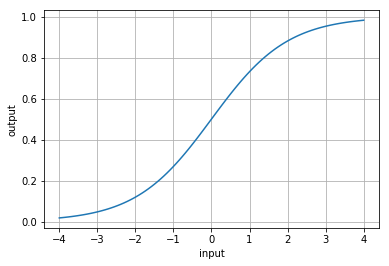

In [4]:
x = np.linspace(-4, +4, 100)
sigmoid = Sigmoid()

y = np.ravel(sigmoid(x.reshape(-1, 1, 1)))
# equal to call of sigmoid.forward(x)
    
plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()

## Relu

Implement Relu and plot for verification

In [5]:
class Relu(Module):
    def forward(self, z: np.ndarray) -> np.ndarray:
        self.input_cache = z
        # START TODO ################
        h = np.zeros_like(z)
        h[z > 0] = z[z > 0]
        return h
        # END TODO###################

    def backward(self, grad: np.ndarray) -> np.ndarray:
        z = self.input_cache
        # START TODO ################
        modules_grad = np.zeros_like(z)
        modules_grad[z > 0] = 1
        return grad * modules_grad
        # END TODO###################

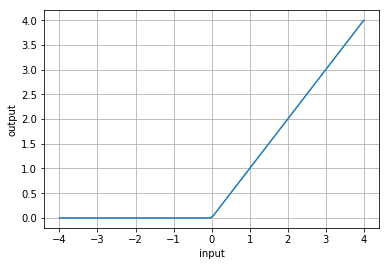

In [6]:
# Plot Relu

# START TODO ################
x = np.linspace(-4, +4, 100)
relu = Relu()

y = np.ravel(relu(x.reshape(-1, 1, 1)))
# equal to call of relu.forward(x)
    
plt.plot(x,y)
plt.xlabel('input')
plt.ylabel('output')
plt.grid(True)
plt.show()
# END TODO###################

## Softmax

Implement the numerical stable softmax. We will not need the backward pass. 

In [7]:
class Softmax(Module):
    def _softmax(self, z):
        # don't reduce (sum) over batch axis
        reduction_axes = tuple(range(1, len(z.shape))) 
        
        # START TODO ################
        # Shift input for numerical stability.
        h = np.exp(z - np.max(z))
        row_sums = np.sum(h, axis=reduction_axes, keepdims=True)
        h = h / row_sums
        # END TODO###################
        return h
    
    def forward(self, z: np.ndarray) -> np.ndarray:
        h = self._softmax(z)
        return h

    def backward(self, grad) -> np.ndarray:
        error_msg = ("Softmax doesn't need to implement a gradient here, as it's"
                     "only needed in CrossEntropyLoss, where we can simplify"
                     "the gradient for the combined expression.")
        raise NotImplementedError(error_msg)


In [8]:
# Check your softmax
softmax = Softmax()
x = np.array([1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0]).reshape(1, -1, 1)

#print(x.shape)
#print(softmax(x).shape)

# Testcase from https://en.wikipedia.org/wiki/Softmax_function#Example
np.testing.assert_allclose(
    np.ravel(softmax(x)), 
    [0.02364054, 0.06426166, 0.1746813, 0.474833, 0.02364054, 0.06426166, 0.1746813],
    rtol=1e-5, err_msg="Softmax is not correct implemented")


# Linear Layer

Implement a linear (in other frameworks also called dense or fully connected) network layer. 
Here you also have to use the Parameter class.

In [9]:
class Linear(Module):

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        
        w_data = 0.01 * np.random.randn(out_features, in_features)
        self.W = Parameter(w_data, "W")
        
        b_data = 0.01 * np.ones((out_features, 1))
        self.b = Parameter(b_data, "b")

    def forward(self, x: np.ndarray) -> np.ndarray:
        assert len(x.shape) == 3, ("x.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(x.shape))
        self.input_cache = x
        # START TODO ################
        # Remember: Access weight data through self.W.data
        z = np.matmul(self.W.data, x) + self.b.data
        return z
        # END TODO ##################

    def backward(self, grad: np.ndarray) -> np.ndarray:
        x = self.input_cache
        
        # START TODO ################
        # x.shape = (2, 10, 1)
        # grad.shape = (2, 30, 1)
        # assert not np.allclose(grad, 0)
        x_transpose = np.transpose(x, [0, 2, 1])
        self.W.grad += np.sum(np.matmul(grad, x_transpose), axis=0)
        self.b.grad += np.sum(grad, axis=0)
        # assert not np.allclose(self.W.grad, 0)
        # assert not np.allclose(self.b.grad, 0)
        # print("Linear backward")
        return np.matmul(self.W.data.T, grad)
        # END TODO ##################
    

    def parameters(self) -> List[Parameter]:
        # START TODO ################ 
        # Return all parameters of Linear
        return [self.W, self.b]
        # END TODO ##################

# Cost Functions



In [10]:
# Define the Cross-Entropy cost functions
class CrossEntropyLoss(Module):
    """Compute the cross entropy."""

    def __init__(self):
        super().__init__()
        self.softmax = Softmax()

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Compute the cross entropy, mean over batch size."""
        y_hat = self.softmax(a)
        self.input_cache = y_hat, y
        batch_size = y_hat.shape[0]
        return -np.sum(np.log(y_hat[y == 1])) / batch_size

    def backward(self, _=None) -> np.ndarray:
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg.
        y_hat, y = self.input_cache

        # START TODO ################
        batch_size, dims = y_hat.shape[0], y_hat.shape[1]
        grad = np.zeros_like(y)

        for i in range(batch_size):
            for j in range(dims):
                for d in range(dims):
                    tmp = y[i, d] / y_hat[i, d]
                    if d == j:
                        tmp *= y_hat[i, d] * (1 - y_hat[i, d])
                    else:
                        tmp *= -y_hat[i, d] * y_hat[i, j]
                    grad[i, j] += tmp
        
        grad = -grad / batch_size
        grad = np.expand_dims(grad, axis=2)
        # END TODO ##################
        # coded by Borna

        assert len(grad.shape) == 3, ("CrossEntropyLoss.backward should return (batch_size, grad_size, 1)"
                                      " but is {}.".format(grad.shape))
        return grad


class MSELoss(Module):
    """Compute the mean squared error loss."""

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        y_hat = a
        batch_size = y_hat.shape[0]
        self.input_cache = y_hat, y
        return np.sum(0.5 * np.linalg.norm(y_hat - y, axis=-1)**2) / batch_size

    def backward(self, _=None):
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg
        y_hat, y = self.input_cache
        
        # START TODO ################
        batch_size = y_hat.shape[0]
        grad = 1 / batch_size * (y_hat - y)
        grad = np.expand_dims(grad, axis=2)
        # END TODO ##################
        # coded by Borna
        
        assert len(grad.shape) == 3, ("MSELossCrossEntropyLoss.backward should return (batch_size, grad_size, 1)"
                                      " but is {}.".format(z.shape))
        return grad

# Sequential Network

In [11]:
class Sequential(Module):
    """A sequential container to stack modules.

    Modules will be added to it in the order they are passed to the
    constructor.

    Example network with one hidden layer:
    model = Sequential(
                  Linear(5,10),
                  ReLU(),
                  Linear(10,10),
                )
    """
    def __init__(self, *args: List[Module]):
        super().__init__()
        self.modules = args

    def forward(self, x: np.ndarray) -> np.ndarray:
        # START TODO ################
        out = x
        for module in self.modules:
            out = module(out) 
        # print("Sequential forward")
        return out
        # END TODO ##################
        # coded by Borna

    def backward(self, grad: np.ndarray) -> np.ndarray:
        # START TODO ################ 
        for module in reversed(self.modules):
            grad = module.backward(grad)
            #if np.allclose(grad, 0):
            #    raise ValueError("{} produced zero grad!".format(module))
        # END TODO ##################
        # coded by Borna
        # print("Sequential backward")
        return grad

    def parameters(self) -> List[Parameter]:
        # iterate over modules and retrieve their parameters, iterate over
        # parameters to flatten the list
        return [param for module in self.modules
                for param in module.parameters()]

# One hot encoding
To handle categorical data, we need to implement the one_hot_encoding utility function.

In [12]:
def one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """Convert integer labels to one hot encoding.

    Example: y=[1, 2] --> [[0, 1, 0], [0, 0, 1]]
    """
    # START TODO ################
    batch_size = y.shape[0]
    encoded = np.zeros(shape = (batch_size, num_classes))
    for batch_idx, label in enumerate(y):
        encoded[batch_idx, label] = 1
    # END TODO ##################
    # coded by Borna
    return encoded


y = np.array([1, 2, 0])
np.testing.assert_equal(one_hot_encoding(y, 3), [[0, 1, 0], [0, 0, 1], [1, 0, 0]])

# Gradient Check

Gradient checking is a useful utility to check, whether forward and backward pass are matching. 
Backward passes are approximated by finite differences of the forward pass.
We have implemented the gradient checking in the Module class for you. As all classes we defined up to here inherit from Module, we can run `check_gradients`.

In [13]:
input_vector = np.random.uniform(-1., 1., size=(2, 10, 1))
input_args = (input_vector,)

# layers + activations
Relu().check_gradients(input_args)
Sigmoid().check_gradients(input_args)
Linear(10, 30).check_gradients(input_args)

# MLP
# START TODO ################ 
# gradient check a Sequential network with 
# layers: linear, sigmoid, linear, sigmoid
Sequential(
    Linear(10, 30),
    Sigmoid(),
    Linear(30, 15),
    Sigmoid()
).check_gradients(input_args)
# END TODO ##################

# losses
input_args_losses = (one_hot_encoding(np.array([1, 2]), 3),  # a
                     one_hot_encoding(np.array([1, 1]), 3))  # y (ground truth)
MSELoss().check_gradients(input_args_losses)
CrossEntropyLoss().check_gradients(input_args_losses)


# Optimizers

Below you see the base class for all optimizers. An Optimizer needs to implement the `step()` function, which updates the parameters passed to the constructor.

In [14]:
class Optimizer:
    """The base class for optimizers.

    All optimizers must implement a step() method that updates the parameters.
    The general optimization loop then looks like this:

    for inputs, targets in dataset:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    `zero_grad` initializes the gradients of the parameters to zero. This
    allows to accumulate gradients (instead of replacing it) during
    backpropagation, which is e.g. useful for skip connections.
    """

    def __init__(self, params: Iterable[Parameter]):
        """
        Args:
            params: The parameters to be optimized.
        """
        self._params = params

    def step(self) -> None:
        """Update the parameters."""
        raise NotImplementedError

    def zero_grad(self) -> None:
        """Clear the gradients of all optimized parameters."""
        for param in self._params:
            assert isinstance(param, Parameter)
            param.grad = np.zeros_like(param.data)

## SGD

Implement stochastic gradient descent (Chapter 5, Chapter 8). 
The momentum parameter improves training speed (Chapter 8.3).

In [15]:
class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD) optimizer with optional Momentum."""

    def __init__(self, params: Iterable[Parameter], lr: float,
                 momentum: Optional[float] = None):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        if momentum:
            for param in self._params:
                param.state_dict["momentum"] = np.zeros_like(param.data)

    def step(self):
        for param in self._params:
            if self.momentum:
                # SGD with Momentum
                # START TODO ################
                v = param.state_dict["momentum"]
                # assert not np.allclose(param.grad, 0)
                v = self.momentum * v - self.lr * param.grad
                param.data = param.data + v
                param.state_dict["momentum"] = v
                # END TODO ##################
            else:
                # Standard SGD
                # START TODO ################
                param.data = param.data - self.lr * param.grad
                # END TODO ##################

## Data Loading

In [16]:
def load_mnist_data():
    """Loads the data, returns training_data, validation_data, test_data."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        return pickle.load(f, encoding='latin1')


def minibatched(data: np.ndarray, batch_size: int) -> List[np.ndarray]:
    assert len(data) % batch_size == 0, ("Data length {} is not multiple of batch size {}"
                                         .format(len(data), batch_size))
    return data.reshape(-1, batch_size, *data.shape[1:])


(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist_data()
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print("x_train shape:", x_train.shape)

num_classes = 10
y_train = one_hot_encoding(y_train, num_classes)
y_val = one_hot_encoding(y_val, num_classes)
y_test = one_hot_encoding(y_test, num_classes)

x_train shape: (50000, 784, 1)


## Training

Implement the actual training loop.

In [17]:
def accuracy(y, predictions, y_is_onehot: bool = False) -> float:
    y_predicted = np.argmax(predictions, axis=-1)
    y = np.argmax(y, axis=-1)
    return np.sum(np.equal(y_predicted, y)) / len(y)


def evaluate(data, labels, model, batch_size):
    predictions = []
    eval_cost = 0.
    data_batched = minibatched(data, batch_size)
    labels_batched = minibatched(labels, batch_size)

    for x, y in zip(data_batched, labels_batched):
        h_1 = np.squeeze(model(x))
        predictions.append(h_1)
        eval_cost += loss_fn(h_1, y)
    predictions = np.array(predictions).reshape(-1, 10)
    eval_accuracy = accuracy(y_val, predictions, False)
    return eval_accuracy, eval_cost


def train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size):
    train_costs, train_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    eval_costs, eval_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    ix = np.arange(len(x_train))
    
    for epoch in range(num_epochs):
        print("Epoch {} / {}:".format(epoch + 1, num_epochs))
        training_predictions = []
        
        np.random.shuffle(ix)
        x_train_batched = minibatched(x_train[ix], batch_size)
        y_train_batched = minibatched(y_train[ix], batch_size)
        
        # train for one epoch
        for x_batch, y_batch in zip(x_train_batched, y_train_batched):
            # START TODO ################ 
            optimizer.zero_grad()
            y_hat_batch = model(x_batch)
            training_predictions.append(y_hat_batch)
            loss = loss_fn(y_hat_batch, y_batch)
            loss_grad = loss_fn.backward()
            model.backward(loss_grad)
            optimizer.step()
            # TIPP: Look at the optimizer's docstring about how to use it.
            #       You might have to add / remove an axis.
            # END TODO ##################
            train_costs[epoch] += loss
       
        training_predictions = np.array(training_predictions).reshape(-1, 10)
        train_accuracies[epoch] = accuracy(y_train[ix], training_predictions, False)
        print("  Training Accuracy: {:.4f}".format(train_accuracies[epoch]))
        print("  Training Cost: {:.4f}".format(train_costs[epoch]))
        eval_accuracies[epoch], eval_costs[epoch] = evaluate(x_val, y_val, model, batch_size)
        print("  Eval Accuracy: {:.4f}".format(eval_accuracies[epoch]))
    return train_costs, train_accuracies, eval_costs, eval_accuracies

** Your feedback on exercise 2.2: ** 

- Time spent: 10 h
- Useful: yes

__MLP Implementation__ section is absolutely awful. While the code is neat and nicely organised, the __lack of instructions__ makes it a nightmare. If we didn't have previous experience with PyTorch, we believe we wouldn't know how to get everything running. 90% of the time we were struggling to match the tensors' shapes (that have an additional dimension 1 or don't). Also, the backpropagation in matrix form is unclear regarding the order of multiplication. That's something we have got right by trial and error.

# Experiments

Apply it on a sequential model (linear, sigmoid, linear, softmax layers). Use the cross entropy loss and sgd with momentum. Use the hyperparameters defined below.

What is the best accuracy you can achieve?

__Answer__  
After 10 epochs:  
Training Accuracy: 97.29 %  
Eval Accuracy: 96.22 %

In [18]:
num_epochs = 10
batch_size = 50
learning_rate = 0.1
momentum = 0.9
linear_units = 30

# START TODO ################ 
# Train the model here!
loss_fn = CrossEntropyLoss()
model = Sequential(
    Linear(x_train.shape[1], linear_units),
    Sigmoid(),
    Linear(linear_units, y_train.shape[1])
)

optimizer = SGD(
    params=model.parameters(),
    lr=learning_rate,
    momentum=momentum
)
train_costs1, train_accuracies1, eval_costs1, eval_accuracies1 = train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size)
# END TODO ##################

Epoch 1 / 10:
  Training Accuracy: 0.8490
  Training Cost: 479.4265
  Eval Accuracy: 0.9413
Epoch 2 / 10:
  Training Accuracy: 0.9439
  Training Cost: 193.7303
  Eval Accuracy: 0.9525
Epoch 3 / 10:
  Training Accuracy: 0.9546
  Training Cost: 156.8279
  Eval Accuracy: 0.9583
Epoch 4 / 10:
  Training Accuracy: 0.9601
  Training Cost: 136.0941
  Eval Accuracy: 0.9594
Epoch 5 / 10:
  Training Accuracy: 0.9645
  Training Cost: 120.2316
  Eval Accuracy: 0.9612
Epoch 6 / 10:
  Training Accuracy: 0.9678
  Training Cost: 109.8730
  Eval Accuracy: 0.9646
Epoch 7 / 10:
  Training Accuracy: 0.9700
  Training Cost: 100.8413
  Eval Accuracy: 0.9658
Epoch 8 / 10:
  Training Accuracy: 0.9716
  Training Cost: 94.2250
  Eval Accuracy: 0.9650
Epoch 9 / 10:
  Training Accuracy: 0.9740
  Training Cost: 87.3070
  Eval Accuracy: 0.9655
Epoch 10 / 10:
  Training Accuracy: 0.9751
  Training Cost: 81.6009
  Eval Accuracy: 0.9637


Now run again with the increased learning rate. Which accuracy can you achieve now? How did the accuracies change while training, compared to the lower learning rate?

**Note:** Make sure, to reinitialize your model's parameters. Don't continue on the already trained parameters.

__Answer__  
After 10 epochs:  
Training Accuracy: 80.09 %  
Eval Accuracy: 80.66 %

The accuracies throughout the whole training were much lower compared to the training with the lower learning rate.

In [19]:
higher_learning_rate = 3

# START TODO ################
loss_fn = CrossEntropyLoss()
higher_model = Sequential(
    Linear(x_train.shape[1], linear_units),
    Sigmoid(),
    Linear(linear_units, y_train.shape[1])
)

higher_optimizer = SGD(
    params=higher_model.parameters(),
    lr=higher_learning_rate,
    momentum=momentum
)
train_costs2, train_accuracies2, eval_costs2, eval_accuracies2 = train(higher_model, loss_fn, higher_optimizer, x_train, y_train, x_val, y_val, num_epochs, batch_size)
# END TODO ##################

Epoch 1 / 10:
  Training Accuracy: 0.1001
  Training Cost: 2454.7996
  Eval Accuracy: 0.0967
Epoch 2 / 10:
  Training Accuracy: 0.1001
  Training Cost: 2450.4147
  Eval Accuracy: 0.0990
Epoch 3 / 10:
  Training Accuracy: 0.1021
  Training Cost: 2454.2696
  Eval Accuracy: 0.0991
Epoch 4 / 10:
  Training Accuracy: 0.1037
  Training Cost: 2450.4102
  Eval Accuracy: 0.1090
Epoch 5 / 10:
  Training Accuracy: 0.1013
  Training Cost: 2453.5220
  Eval Accuracy: 0.0994
Epoch 6 / 10:
  Training Accuracy: 0.1011
  Training Cost: 2449.8821
  Eval Accuracy: 0.1009
Epoch 7 / 10:
  Training Accuracy: 0.1020
  Training Cost: 2454.0353
  Eval Accuracy: 0.1009
Epoch 8 / 10:
  Training Accuracy: 0.1022
  Training Cost: 2471.6026
  Eval Accuracy: 0.0961
Epoch 9 / 10:
  Training Accuracy: 0.1353
  Training Cost: 2366.9194
  Eval Accuracy: 0.1990
Epoch 10 / 10:
  Training Accuracy: 0.2072
  Training Cost: 2159.0485
  Eval Accuracy: 0.2006


Train only a subset of 1000 training samples, but for 300 epochs. 
Plot the costs & accuracies for both training and validation.

How do the accuracies change compared to the previous runs?
How is this plot related to the term 'overfitting'?

__Answer__  
In this case, the training accuracies (perfect; 100%) are significantly higher than the evaluation accuracies (~ 87%). That is a typical sign of overfitting (model memorizes the training samples) and it is best visible from the plot of costs. The training cost drops to a value near 0, while the evaluation cost reaches the best value of ~ 180 and then continues to rise.

In [20]:
num_train_samples = 1000
num_epochs = 300

# START TODO ################ 
x_train_subset = x_train[:num_train_samples, :, :]
y_train_subset = y_train[:num_train_samples, :]
loss_fn = CrossEntropyLoss()
subset_model = Sequential(
    Linear(x_train.shape[1], linear_units),
    Sigmoid(),
    Linear(linear_units, y_train.shape[1])
)

subset_optimizer = SGD(
    params=subset_model.parameters(),
    lr=learning_rate,
    momentum=momentum
)

train_costs3, train_accuracies3, eval_costs3, eval_accuracies3 = train(subset_model, loss_fn, subset_optimizer, x_train_subset, y_train_subset, x_val, y_val, num_epochs, batch_size)
# END TODO ##################

Epoch 1 / 300:
  Training Accuracy: 0.1050
  Training Cost: 46.4335
  Eval Accuracy: 0.1009
Epoch 2 / 300:
  Training Accuracy: 0.1320
  Training Cost: 45.6008
  Eval Accuracy: 0.1646
Epoch 3 / 300:
  Training Accuracy: 0.3630
  Training Cost: 39.8635
  Eval Accuracy: 0.4679
Epoch 4 / 300:
  Training Accuracy: 0.5790
  Training Cost: 27.9660
  Eval Accuracy: 0.6636
Epoch 5 / 300:
  Training Accuracy: 0.7400
  Training Cost: 18.5920
  Eval Accuracy: 0.7737
Epoch 6 / 300:
  Training Accuracy: 0.8220
  Training Cost: 13.3514
  Eval Accuracy: 0.8106
Epoch 7 / 300:
  Training Accuracy: 0.8610
  Training Cost: 10.3958
  Eval Accuracy: 0.8300
Epoch 8 / 300:
  Training Accuracy: 0.8780
  Training Cost: 8.4172
  Eval Accuracy: 0.8449
Epoch 9 / 300:
  Training Accuracy: 0.9030
  Training Cost: 7.0922
  Eval Accuracy: 0.8591
Epoch 10 / 300:
  Training Accuracy: 0.9210
  Training Cost: 6.2475
  Eval Accuracy: 0.8651
Epoch 11 / 300:
  Training Accuracy: 0.9330
  Training Cost: 5.4816
  Eval Accurac

  Training Accuracy: 1.0000
  Training Cost: 0.1639
  Eval Accuracy: 0.8769
Epoch 91 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1615
  Eval Accuracy: 0.8767
Epoch 92 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1593
  Eval Accuracy: 0.8768
Epoch 93 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1567
  Eval Accuracy: 0.8768
Epoch 94 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1540
  Eval Accuracy: 0.8769
Epoch 95 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1519
  Eval Accuracy: 0.8774
Epoch 96 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1502
  Eval Accuracy: 0.8771
Epoch 97 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1480
  Eval Accuracy: 0.8771
Epoch 98 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1456
  Eval Accuracy: 0.8771
Epoch 99 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1436
  Eval Accuracy: 0.8767
Epoch 100 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.1412
  Eval Accuracy: 0.8771
Epo

  Training Accuracy: 1.0000
  Training Cost: 0.0653
  Eval Accuracy: 0.8765
Epoch 180 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0649
  Eval Accuracy: 0.8757
Epoch 181 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0645
  Eval Accuracy: 0.8761
Epoch 182 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0639
  Eval Accuracy: 0.8763
Epoch 183 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0636
  Eval Accuracy: 0.8761
Epoch 184 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0630
  Eval Accuracy: 0.8760
Epoch 185 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0626
  Eval Accuracy: 0.8762
Epoch 186 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0624
  Eval Accuracy: 0.8763
Epoch 187 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0618
  Eval Accuracy: 0.8767
Epoch 188 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0615
  Eval Accuracy: 0.8764
Epoch 189 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0609
  Eval Accuracy: 0

  Training Accuracy: 1.0000
  Training Cost: 0.0397
  Eval Accuracy: 0.8766
Epoch 269 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0395
  Eval Accuracy: 0.8762
Epoch 270 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0393
  Eval Accuracy: 0.8764
Epoch 271 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0391
  Eval Accuracy: 0.8764
Epoch 272 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0389
  Eval Accuracy: 0.8765
Epoch 273 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0387
  Eval Accuracy: 0.8766
Epoch 274 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0386
  Eval Accuracy: 0.8765
Epoch 275 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0384
  Eval Accuracy: 0.8765
Epoch 276 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0383
  Eval Accuracy: 0.8761
Epoch 277 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0381
  Eval Accuracy: 0.8763
Epoch 278 / 300:
  Training Accuracy: 1.0000
  Training Cost: 0.0379
  Eval Accuracy: 0

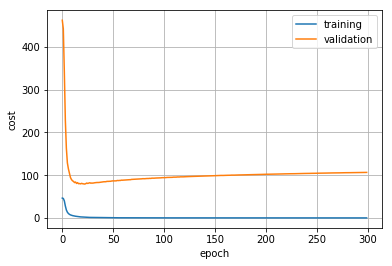

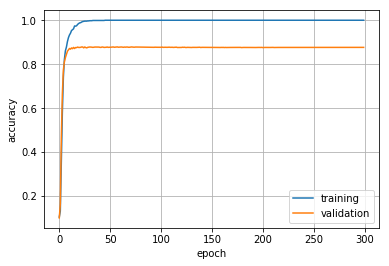

In [21]:
plt.figure(1)
plt.plot(train_costs3, label='training')
plt.plot(eval_costs3, label='validation')
plt.legend(loc='best')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.grid(True)

plt.figure(2)
# Plot accuracies here
# START TODO ################ 
plt.plot(train_accuracies3, label='training')
plt.plot(eval_accuracies3, label='validation')
plt.legend(loc='best')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
# END TODO ##################

plt.show()

** Your feedback on exercise 2.3: ** 

- Time spent: 15 min
- Useful: very

The **Experiments** section is pretty much straightforward. With all the functions and classes already implemented, one can quickly get the results and plot them. Visualizing the costs and accuracies is __a must__ when explaining the overfitting in deep learning. Here we validate that everything implemented is working fine and that the effort was worth it :)